### Created simple parameter : 0.4*OXY + 0.3*SECCHI + 0.3*CHLORA measuring water quality and tried predicting it on models provided at models.ipynb with some small modifications, using elements from fertilizers and silicate as X
### works ok mostly based on silicates,  but other matters too r2_score better at greater depths

In [696]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from zipfile import ZipFile
from functools import reduce

import seaborn as sns

from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from pandas.plotting import scatter_matrix

In [843]:
DATA_BASE = '2022.11.07-merged-single-observation/'
PATHS = ['100', '1000', '1500','2000', '2500', 'average', 'deep', 'standard']
DATA_FILE = '/CLEANED_MERGED_DATA.csv'
DATA_PATH = DATA_BASE + PATHS[6] + DATA_FILE

In [844]:
df = pd.read_csv(DATA_PATH,index_col=False)

In [845]:
#drop date and normalize rest of columns
df = df.drop(['DATE'], axis=1)
cols = list(set(df.columns))
df[cols] -= df[cols].min()
df[cols] /= df[cols].max()

In [846]:
# quality is linear combitnation of few other parameters
# we used elements occuring in fertilizers and SIO2 (silicate) which comes from rivers as X

X_cols = ['TP', 'TN', 'NO3','NO2','PO4', 'NH4', 'SIO2']
df['quality'] = 0.4*df['OXY'] + 0.3*df['SECCHI'] + 0.3*df['CHLORA']
y_col = ['quality']

X = df[X_cols]
y = df[y_col]
y = column_or_1d(y, warn=True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/tmp/ipykernel_17696/2767477533.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [847]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true  ) ) ) * 100

In [848]:
# linear regression
lg = LinearRegression()
lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.003769283778037415
0.04747515597701183
18.54086978235886


In [849]:
# Gradient boosting regression
bg = GradientBoostingRegressor()
bg.fit(x_train, y_train)
y_pred = bg.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.002781166800404722
0.03954562738916771
14.929360578325252


In [832]:
# neural netword
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(x_train,y_train)
y_pred = mlp.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.00876717205837218
0.0727527338365563
24.213420256884177


In [833]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train, y_train)
y_pred = rfr.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.003909006699118161
0.0481823691912271
14.222663877484552


1 SIO2 0.2904536539002279
2 NO3 0.25903165197147665
3 NH4 0.12391663102810987
4 PO4 0.0993645151351434
5 TN 0.08161297943249939
6 TP 0.07653761035852134


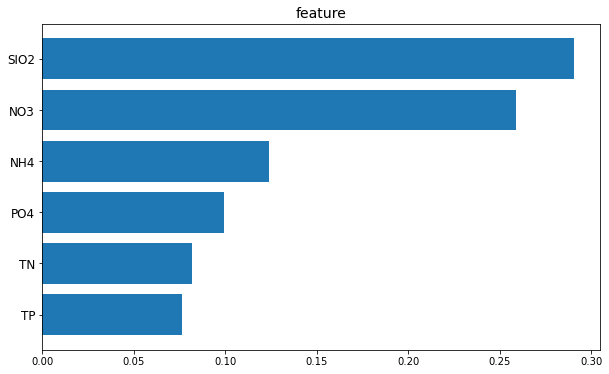

In [823]:
feat_lebels = x_train.columns[0:]
importances  = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for i,j in zip(range(x_train.shape[1]-1),indices):
    index_list.append(feat_lebels[j])
    value_list.append(importances[j])
    print(i+1, feat_lebels[j], importances[j])

plt.figure(figsize=(10,6))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize = 12)
plt.title('feature',fontsize = 14)
plt.show()

In [793]:
# find best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[50,75,100],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(x_train, y_train)
best = grid_seach_rf.best_params_
print(best)

{'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 75}


In [794]:
best

{'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 75}

In [795]:
# model
rfr_ = RandomForestRegressor(n_estimators=best['n_estimators'], min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'], random_state=0)
rfr_.fit(x_train, y_train)
y_pred = rfr_.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.0037402553124748312
17.634557163076238


In [850]:
# score

from sklearn.metrics import r2_score
regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5)
regressor.fit(x_train, y_train) 
y_pred = regressor.predict(x_test)
print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  

errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:\n', np.round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:\n', round(accuracy, 2), '%.')

sklearn score:0.7161520757582722
Mean Absolute Error:
 0.04 degrees.
Accuracy:
 84.88 %.


In [797]:
col = y_pred.shape[0]
y_pred = pd.DataFrame(y_pred[-col:], index=range(col), columns=['quality'])

In [798]:
y_test.shape[0]

137

In [799]:
y_pred

,quality
0,0.225702
1,0.491816
2,0.314448
3,0.260065
4,0.349421
...,...
132,0.170632
133,0.408798
134,0.451673
135,0.441019


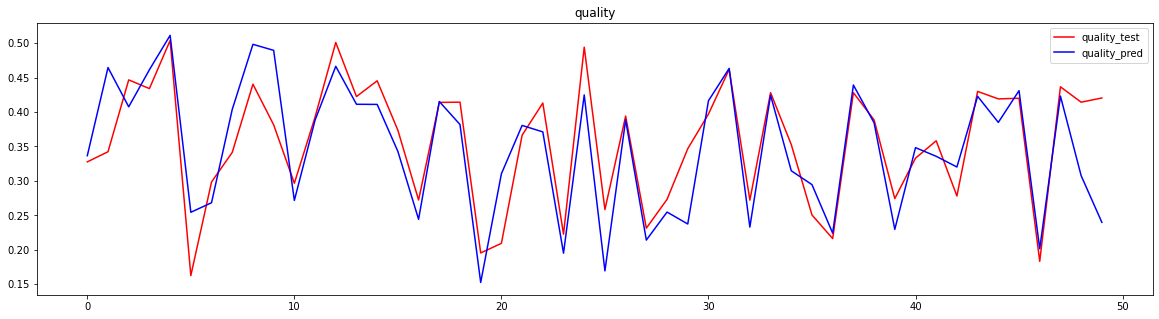

In [813]:
plt.figure(figsize=(20, 5))
plt.plot(y_test[150:200], color='red', label='quality_test')
plt.plot(y_pred[150:200], color='blue', label='quality_pred')
plt.legend(loc="upper right")
plt.title("quality")
plt.show()
